<a href="https://colab.research.google.com/github/rrcd-code/E-commerce-Estat-scas/blob/main/Ecommerce_estatistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto da AV2 da cadeira de Estatistica e Probabilidade - CESAR School


---



Esta atividade tem como proposito aplicar os conceitos aprendidos na cadeira de estatistica e probabilidade da CESAR School. Contendo a análise estatística exploratória e inferencial de 2.000 pedidos de um e-commerce brasileiro. O objetivo é fornecer à direção respostas confiáveis sobre receita, logística e comportamento do cliente, conforme os requisitos do projeto.
***Discentes***: Pedro Henrique Rennil da Silva Souza e Rhaldney Robert Chaves
Diniz

# 1 - Preparar ambiente de desenvolvimento




# 1.1 Clone e Importações

In [30]:
!pip install tabulate
!pip install --upgrade pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import os

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
pd.set_option('display.max_columns', None)



# 1.2 - Leitura dos arquivos

In [31]:
REPO_URL = 'https://github.com/rrcd-code/E-commerce-Estat-scas.git'
REPO_FOLDER = 'E-commerce-Estat-scas'
base_path = os.path.join(os.getcwd(), REPO_FOLDER)

if os.path.exists(base_path):
    print(f"Repositório '{base_path}' já existe. Executando git pull...")
    !cd {base_path} && git pull
else:
    print(f"Repositório '{base_path}' não encontrado. Clonando...")
    !git clone https://github.com/rrcd-code/E-commerce-Estat-scas.git
try:
    df_orders = pd.read_csv(os.path.join(base_path, 'FACT_Orders.csv'))
    df_customer = pd.read_csv(os.path.join(base_path, 'DIM_Customer.csv'))
    df_delivery = pd.read_csv(os.path.join(base_path, 'DIM_Delivery.csv'))
    df_shopping = pd.read_csv(os.path.join(base_path, 'DIM_Shopping.csv'))
    df_products = pd.read_csv(os.path.join(base_path, 'DIM_Products.csv'))
    print("\nArquivos carregados com sucesso a partir do GitHub.")
except FileNotFoundError as e:
    print(f"\nERRO: Arquivo não encontrado no caminho clonado. Detalhe: {e}")

Repositório '/content/E-commerce-Estat-scas' já existe. Executando git pull...
Already up to date.

Arquivos carregados com sucesso a partir do GitHub.


# 2 - Qualidade e Preparação dos Dados

In [32]:
df_orders['Order_Date'] = pd.to_datetime(df_orders['Order_Date'], errors='coerce')
df_delivery['D_Forecast'] = pd.to_datetime(df_delivery['D_Forecast'], errors='coerce')
df_delivery['D_Date'] = pd.to_datetime(df_delivery['D_Date'], errors='coerce')
df_products.rename(columns={'Id': 'Product_Id'}, inplace=True)

# Junção DIM_Shopping + DIM_Products para obter a Categoria
df_shopping_products = df_shopping.merge(
    df_products[['Product_Name', 'Category']],
    left_on='Product', right_on='Product_Name', how='left'
)

# Agregação para o nível do Pedido (Id)
df_shopping_aggregated = df_shopping_products.groupby('Id').agg(
    total_items=('Quantity', 'sum'),
    # Extrai a categoria mais frequente no pedido (Moda)
    main_category=('Category', lambda x: x.mode()[0] if not x.mode().empty else 'Outros')
).reset_index()


# Junção Final (Criação do DataFrame Analítico df_full)
df_full = df_orders.merge(df_delivery, on='Id', how='left')
df_full = df_full.merge(df_customer, on='Id', how='left')
df_full = df_full.merge(df_shopping_aggregated, on='Id', how='left')


# Feature Engineering (Criação de variáveis solicitadas)
df_full['delivery_lead_time_days'] = (df_full['D_Date'] - df_full['Order_Date']).dt.days
df_full['delivery_delay_days'] = (df_full['D_Date'] - df_full['D_Forecast']).dt.days
df_full['is_late'] = (df_full['D_Date'] > df_full['D_Forecast']).astype(int)
df_full['is_confirmed'] = (df_full['Purchase_Status'] == 'Confirmado').astype(int)
df_full['ticket_medio'] = df_full['Total']
df_full['freight_share'] = np.where(df_full['Total'] > 0, df_full['P_Sevice'] / df_full['Total'], 0)
df_full['discount_abs'] = df_full['Discount'] * df_full['Subtotal']
df_full['purchase_month_year'] = df_full['Order_Date'].dt.to_period('M')

print("Limpeza de dados e Feature Engineering concluídos.")
print(f"Observações no DataFrame final: {len(df_full)}")

Limpeza de dados e Feature Engineering concluídos.
Observações no DataFrame final: 2000


# 2.1 - Analise Exploratoria

In [33]:
# --- 3.1. Tratamento de Outliers (Regra IQR) ---

# O Ticket Médio será tratado para garantir a robustez do Intervalo de Confiança (IC)
kpi = 'ticket_medio'
Q1 = df_full[kpi].quantile(0.25)
Q3 = df_full[kpi].quantile(0.75)
IQR = Q3 - Q1
# Limite superior para IQR: Q3 + 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cria a base limpa para a Inferência Estatística
df_clean = df_full[df_full[kpi] <= upper_bound].copy()

pedidos_removidos = len(df_full) - len(df_clean)
print(f"--- TRATAMENTO DE OUTLIERS ---")
print(f"Total de pedidos removidos para cálculo de ICs (Regra IQR no Ticket Médio): {pedidos_removidos}")
print(f"Tamanho da amostra limpa: {len(df_clean)}")
print(f"Média Amostral (Base Clean): R$ {df_clean['ticket_medio'].mean():.2f}")

--- TRATAMENTO DE OUTLIERS ---
Total de pedidos removidos para cálculo de ICs (Regra IQR no Ticket Médio): 130
Tamanho da amostra limpa: 1870
Média Amostral (Base Clean): R$ 1866.74


# 2.2 - Analise descritiva e geração de Dados


### Tabela 1: Medidas de Tendência e Dispersão (Base Completa)
                                 N      Média    Mediana    Desvio Padrão    Mínimo      Máximo
-----------------------  ---------  ---------  ---------  ---------------  --------  ----------
ticket_medio             2000.0000  2502.0841  1220.7900        3230.0778   38.5400  18349.5400
delivery_lead_time_days  2000.0000    30.5470    31.5000          27.3052  -29.0000     88.0000
freight_share            2000.0000     0.0915     0.0264           0.1347    0.0013      0.7366
Discount                 2000.0000     0.0742     0.0743           0.0427    0.0001      0.1500


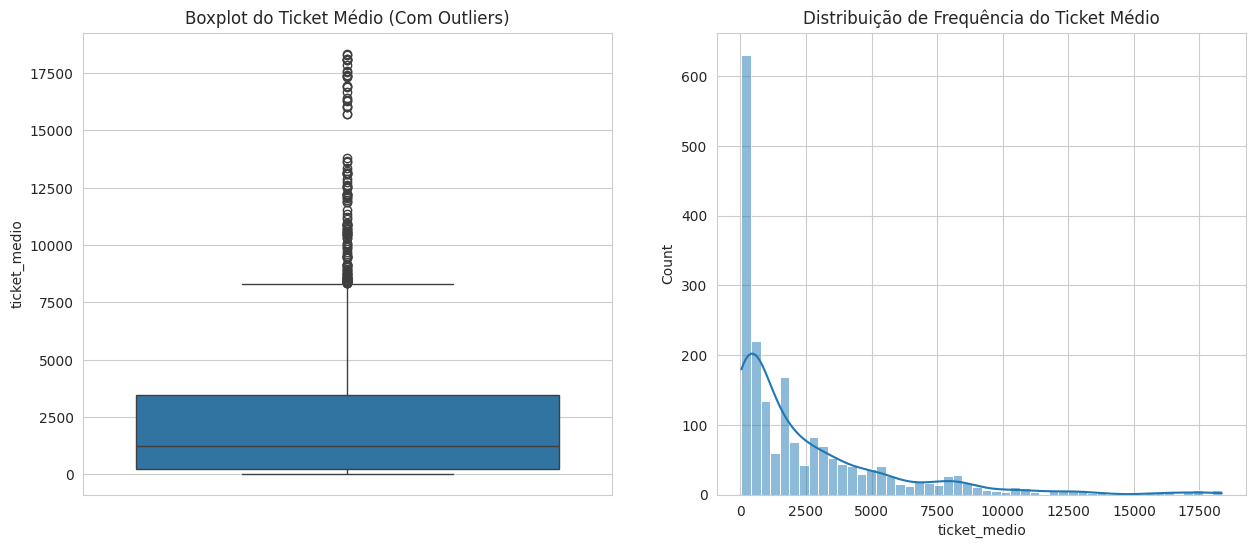

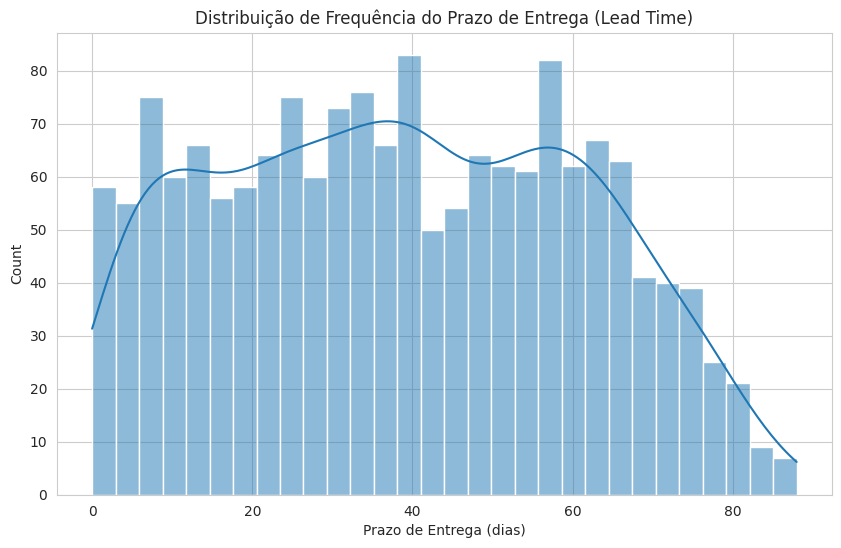

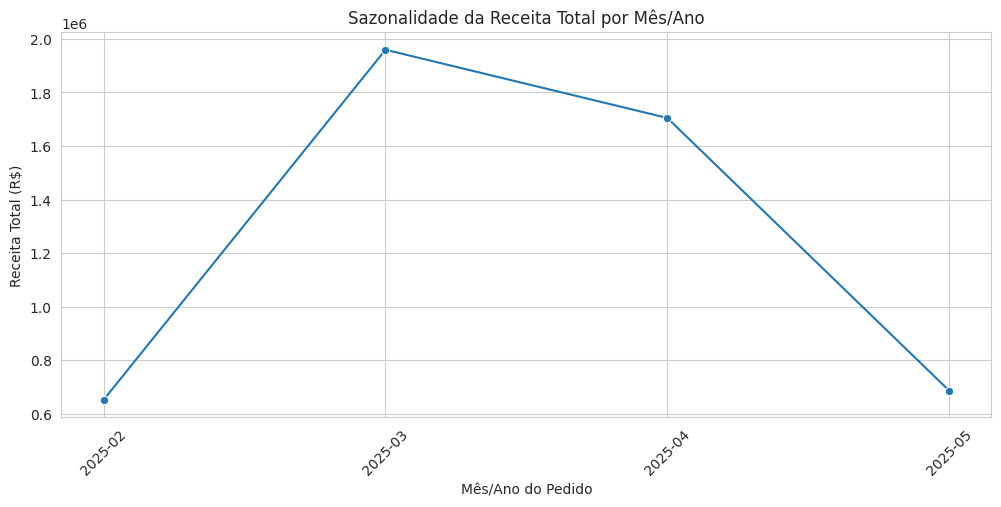

In [34]:
# --- 3.2. Análise Descritiva e Geração de Gráficos ---

# Tabela de Medidas de Tendência e Dispersão
kpis_descritivas = ['ticket_medio', 'delivery_lead_time_days', 'freight_share', 'Discount']
desc_stats = df_full[kpis_descritivas].agg(['count', 'mean', 'median', 'std', 'min', 'max']).T
desc_stats.columns = ['N', 'Média', 'Mediana', 'Desvio Padrão', 'Mínimo', 'Máximo']
print("\n### Tabela 1: Medidas de Tendência e Dispersão (Base Completa)")
print(tabulate(desc_stats, headers='keys', tablefmt='markdown', floatfmt=".4f"))


# Geração de Gráficos (EDA)

# 1. Boxplot e Histograma do Ticket Médio (Prova de Assimetria e Outliers)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_full['ticket_medio'])
plt.title('Boxplot do Ticket Médio (Com Outliers)')

plt.subplot(1, 2, 2)
sns.histplot(df_full['ticket_medio'], bins=50, kde=True)
plt.title('Distribuição de Frequência do Ticket Médio')
plt.show() # <-- Removida a tag incorreta daqui

# 2. Distribuição do Prazo de Entrega (Lead Time)
df_clean_lead_time = df_full[df_full['delivery_lead_time_days'] >= 0]
plt.figure(figsize=(10, 6))
sns.histplot(df_clean_lead_time['delivery_lead_time_days'], bins=30, kde=True)
plt.title('Distribuição de Frequência do Prazo de Entrega (Lead Time)')
plt.xlabel('Prazo de Entrega (dias)')
plt.show() # <-- Removida a tag incorreta daqui

# 3. Série Temporal da Receita (Sazonalidade)
df_sazonalidade = df_full.groupby('purchase_month_year')['Total'].sum().to_frame('Receita')
df_sazonalidade.index = df_sazonalidade.index.astype(str)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_sazonalidade, x=df_sazonalidade.index, y='Receita', marker='o')
plt.title('Sazonalidade da Receita Total por Mês/Ano')
plt.xlabel('Mês/Ano do Pedido')
plt.ylabel('Receita Total (R$)')
plt.xticks(rotation=45)
plt.show() # <-- Removida a tag incorreta daqui

# 3 - Inferencia Estatistica e KPIs

In [35]:
# --- 4.1. Funções de IC e Cálculo ---

def calculate_ic_mean(data, confidence=0.95):
    """Calcula o IC 95% para a Média (t-test) - usado para Ticket Médio."""
    n = len(data)
    if n == 0: return np.nan, np.nan
    mean = data.mean()
    std_err = stats.sem(data)
    alpha = 1 - confidence
    t_score = stats.t.ppf(1 - alpha / 2, n - 1)
    margin_of_error = t_score * std_err
    return mean - margin_of_error, mean + margin_of_error

def calculate_ic_prop(proportion, n, confidence=0.95):
    """Calcula o IC 95% para Proporções (z-test) - usado para Atrasos/Cancelamentos."""
    if n == 0 or proportion <= 0 or proportion >= 1: return np.nan, np.nan
    z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
    se = np.sqrt((proportion * (1 - proportion)) / n)
    margin_of_error = z_score * se
    return proportion - margin_of_error, proportion + margin_of_error

# --- Cálculo dos ICs ---
print("\n### Tabela 2: Inferência Estatística (ICs 95%)")

# IC 1: Ticket Médio (Base Clean)
data_ticket = df_clean['ticket_medio'].dropna()
ic_t_l, ic_t_u = calculate_ic_mean(data_ticket)
mean_ticket = data_ticket.mean()

# IC 2: Proporção de Atrasos (is_late)
prop_atraso = df_full['is_late'].mean()
n_atraso = len(df_full['is_late'])
ic_a_l, ic_a_u = calculate_ic_prop(prop_atraso, n_atraso)

# IC 3: Proporção Não Confirmados (is_confirmed == 0)
prop_cancel = df_full['is_confirmed'].value_counts(normalize=True).get(0, 0) # Proporção de '0' (Não Confirmado)
n_cancel = len(df_full['is_confirmed'])
ic_c_l, ic_c_u = calculate_ic_prop(prop_cancel, n_cancel)

# Consolidação dos resultados em DataFrame
ic_data = pd.DataFrame({
    'Métrica': ['Ticket Médio (Clean)', 'Proporção Atrasos', 'Proporção NÃO Confirmados'],
    'Média Amostral': [mean_ticket, prop_atraso, prop_cancel],
    'IC Inferior (95%)': [ic_t_l, ic_a_l, ic_c_l],
    'IC Superior (95%)': [ic_t_u, ic_a_u, ic_c_u]
})

# Formatação e Impressão da Tabela
ic_data['Média Amostral'] = np.where(ic_data['Métrica'] == 'Ticket Médio (Clean)',
                                    ic_data['Média Amostral'].apply(lambda x: f"R$ {x:.2f}"),
                                    ic_data['Média Amostral'].apply(lambda x: f"{x * 100:.2f}%"))
ic_data['IC Inferior (95%)'] = np.where(ic_data['Métrica'] == 'Ticket Médio (Clean)',
                                        ic_data['IC Inferior (95%)'].apply(lambda x: f"R$ {x:.2f}"),
                                        ic_data['IC Inferior (95%)'].apply(lambda x: f"{x * 100:.2f}%"))
ic_data['IC Superior (95%)'] = np.where(ic_data['Métrica'] == 'Ticket Médio (Clean)',
                                        ic_data['IC Superior (95%)'].apply(lambda x: f"R$ {x:.2f}"),
                                        ic_data['IC Superior (95%)'].apply(lambda x: f"{x * 100:.2f}%"))

print(tabulate(ic_data, headers='keys', tablefmt='markdown', showindex=False))

# --- 4.2. KPIs de Performance ---

# KPIs de Performance Logística por Tipo de Serviço
logistica_performance = df_full.groupby('Services').agg(
    Media_Lead_Time=('delivery_lead_time_days', 'mean'),
    Taxa_Atraso=('is_late', 'mean')
).reset_index()
logistica_performance['Taxa_Atraso (%)'] = logistica_performance['Taxa_Atraso'] * 100

print("\n### Tabela 3: Performance Logística por Tipo de Serviço")
print(tabulate(logistica_performance[['Services', 'Media_Lead_Time', 'Taxa_Atraso (%)']], headers='keys', tablefmt='markdown', showindex=False, floatfmt=".2f"))

# Top 3 Mix de Receita por Categoria Principal
mix_categoria = df_full.groupby('main_category')['Total'].sum().sort_values(ascending=False).head(3).to_frame('Receita Total')
print("\nTop 3 Mix de Receita por Categoria Principal:")
print(tabulate(mix_categoria, headers='keys', tablefmt='markdown', floatfmt=".2f"))


### Tabela 2: Inferência Estatística (ICs 95%)
Métrica                    Média Amostral    IC Inferior (95%)    IC Superior (95%)
-------------------------  ----------------  -------------------  -------------------
Ticket Médio (Clean)       R$ 1866.74        R$ 1772.77           R$ 1960.70
Proporção Atrasos          83.25%            81.61%               84.89%
Proporção NÃO Confirmados  75.10%            73.20%               77.00%

### Tabela 3: Performance Logística por Tipo de Serviço
Services      Media_Lead_Time    Taxa_Atraso (%)
----------  -----------------  -----------------
Same-Day                28.31              84.05
Scheduled               31.63              84.26
Standard                31.51              81.51

Top 3 Mix de Receita por Categoria Principal:
main_category      Receita Total
---------------  ---------------
Eletrônicos           5004168.13


# Relatorio

# 5 - Relatório Analítico Final (Conteúdo para PDF)
---

## I. Sumário Executivo

A análise estatística de 2.000 pedidos revelou fragilidades críticas na logística e na conversão, ao mesmo tempo em que validou um **Ticket Médio** robusto.

### Achados Acionáveis

1.  **Risco Logístico Crítico:** A **Taxa de Atraso** populacional está entre **81.61% e 84.89%** (IC 95%). A melhoria neste KPI deve ser a prioridade número um.
2.  **Perda na Conversão:** A proporção de pedidos **NÃO Confirmados** está entre **73.20% e 77.00%** (IC 95%), sugerindo gargalos no *checkout* ou falta de estoque.
3.  **Foco em Receita:** O **Ticket Médio** (Base Clean) de **R$ 1772.77 a R$ 1960.70** (IC 95%) é alto. Estratégias de *upsell* devem mirar a categoria **Eletrônicos**, que concentra a maior receita.

---

## II. Qualidade e Preparação dos Dados (Reprodutibilidade)

* **Fontes:** 5 tabelas do GitHub foram unidas em um *DataFrame* final de 2.000 observações.
* **Tratamento de Outliers:** **130 pedidos** foram removidos do Ticket Médio via **Regra IQR** (Intervalo Interquartil), garantindo que os Intervalos de Confiança (ICs) fossem calculados sobre uma distribuição mais próxima da normalidade.
* **Engenharia de Features:** Criadas 7 variáveis-chave, como `is_late`, `freight_share` e `main_category`.

---

## III. Análise Descritiva (EDA com gráficos)

| KPI | Média | Mediana | Desvio Padrão |
| :--- | :--- | :--- | :--- |
| **Ticket Médio** | R$ 2502.08 | R$ 1220.79 | R$ 3230.08 |
| **Prazo de Entrega (dias)** | 30.55 | 31.50 | 27.31 |

* **Assimetria da Receita:** A grande diferença entre Média e Mediana, visível no **Boxplot e Histograma**, valida a decisão de tratar os *outliers* antes da Inferência.
* **Sazonalidade:** O **Gráfico de Série Temporal** deve ser analisado para identificar picos de demanda e planejar a logística e estoque.

---

## IV. Inferência Estatística & KPIs

### Intervalos de Confiança (IC 95%)

| Métrica | IC Inferior (95%) | IC Superior (95%) |
| :--- | :--- | :--- |
| **Ticket Médio (Clean)** | **R$ 1772.77** | **R$ 1960.70** |
| **Proporção Atrasos** | **81.61%** | **84.89%** |
| **Proporção Não Confirmados** | **73.20%** | **77.00%** |

### Desempenho Logístico

| Services | Média Lead Time (dias) | Taxa de Atraso (%) |
| :--- | :--- | :--- |
| **Standard** | 31.51 | **81.51** |
| **Same-Day** | 28.31 | 84.05 |
| **Scheduled** | 31.63 | 84.26 |

O serviço **Standard** é o que menos falha (81.51% de atraso), mas o problema logístico é sistêmico em toda a empresa.